In [53]:
# %load genetic_algorithm.py
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
# import main_func
import facebook_datacollector
import pandas as pd
import mysql_adactivity_save

# sizepop, vardim, MAXGEN, params = 2000, 3, 30, [0.9, 0.5, 0.5]
sizepop, vardim, MAXGEN, params = 1000, 3, 10, [0.9, 0.5, 0.5]
OBJECTIVE_LIST = ['LINK_CLICKS', 'POST_ENGAGEMENT', 'ALL_CLICKS', 'VIDEO_VIEWS', 'IMPRESSIONS']
class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print ("Optimal solution is:")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()

class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        self.fitness = ObjectiveFunc.fitnessfunc( self.chrom, df )
        
class ObjectiveFunc(object):
    '''
    objective function of genetic algorithm
    '''
    def fitnessfunc(optimal_weight, df):
        m_kpi   = df['campaign_charge'] / df['charge_per_day']
        m_spend = -( df['budget_per_day'] - df['spend'] ) / df['budget_per_day']
        m_bid   = ( df['campaign_bid'] - df['campaign_cpc'] ) / df['campaign_bid']
        m_width = df['impressions'] / df['budget_per_day']
#         m_ctr   = ctr/target_ctr 

        status  = np.array( [m_kpi, m_spend, m_bid] )
#         print(df['campaign_bid'].iloc[0], df['campaign_cpc'].iloc[0], df['campaign_bid'].iloc[0])
#         status  = np.array( [m_kpi, m_spend, m_bid, m_width] )
        r = np.dot( optimal_weight, status )
        return r

    def adset_fitness(optimal_weight, df):
        df = df.fillna(0)
        m_kpi = df['target'] / df['daily_charge'] * 10
        if df['target'].iloc[0] == 0:
            m_kpi = -10
        m_spend = -( df['daily_budget'] - df['spend'] ) / df['daily_budget']
        m_bid   = ( df['bid_amount'] - df['cost_per_target'] ) / df['bid_amount']
        status  = np.array( [m_kpi, m_spend.iloc[0], m_bid.iloc[0]] )

        for idx, j in enumerate(status):
            if np.isinf(idx) or np.isneginf(idx):
                status[idx] = -100
        status = np.nan_to_num(status)
        optimal_weight = np.array([
            optimal_weight['weight_kpi'].iloc[0],
            optimal_weight['weight_spend'].iloc[0],
            optimal_weight['weight_bid'].iloc[0]
        ])
        r = np.dot( optimal_weight, status )
#         print(status)
#         print(optimal_weight)
        return r
    
    def campaign_status( campaign_id ):
        mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %(campaign_id), con=mydb)
        charge_type = df_camp['charge_type'].iloc[0]
        df_camp['charge_per_day'] = df_camp['target']/df_camp['period']
        df_camp['campaign_bid'] = df_camp['spend_cap']/df_camp['destination']
        insights = facebook_datacollector.Campaigns(campaign_id, charge_type).get_campaign_insights()
        if bool(insights):
            spend = int( insights.get("spend") )
            campaign_cpc = float( insights.get("cost_per_target") )
            campaign_charge = int( insights.get("target") )
            impressions = int( insights.get("impressions") )
        else:
            spend = 0
            campaign_cpc = 0
            campaign_charge = 0
            impressions = 0
        df=pd.DataFrame({
            'campaign_id':[campaign_id],
            'campaign_cpc':[campaign_cpc],
            'campaign_charge':[campaign_charge],
            'impressions':[impressions],
            'campaign_bid':[df_camp['campaign_bid'].iloc[0]],
            'spend':[spend],
            'daily_budget':[df_camp['daily_budget'].iloc[0]],
            'charge_per_day':[df_camp['daily_charge'].iloc[0]],
            'budget_per_day':[df_camp['daily_budget'].iloc[0]],
            'charge_type':[df_camp['charge_type'].iloc[0]]
            
        })
        df = df.convert_objects(convert_numeric=True)
        mydb.close()
        return df
    
    def adset_status( adset_id ):
        mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )

        df=pd.DataFrame({'adset_id':[],'target':[], 'impressions':[], 'bid_amount':[]})
        
#         df_ad = pd.read_sql("SELECT * FROM ad_insights WHERE ad_id=%s ORDER BY request_time DESC LIMIT 1" %(ad_id), con=mydb)
#         df_ad = df_ad.apply(pd.to_numeric)
        df_adset = pd.read_sql("SELECT * FROM adset_insights WHERE adset_id=%s ORDER BY request_time DESC LIMIT 1" %(adset_id), con=mydb)
        df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %(df_adset['campaign_id'].iloc[0]), con=mydb)
#         df_camp['charge_per_day'] = df_camp['target']/df_camp['campaign_days']
        df_temp = pd.merge( df_adset[['campaign_id', 'adset_id', 'target', 'cost_per_target', 'impressions']],
                              df_adset[['adset_id','spend','bid_amount','daily_budget']],
                              on=['adset_id'] )
        df_camp['campaign_daily_budget'] = df_camp['daily_budget']
        df_status = pd.merge( df_temp,
                              df_camp[['campaign_id', 'daily_charge', 'campaign_daily_budget']],
                              on=['campaign_id'] )
        df = pd.concat([df, df_status], ignore_index=True, sort=True)
#         print(ad_id)
#         print(df[['adset_id', 'charge', 'charge_cpc','bid_amount', 'impressions', 'spend']])
        mydb.close()
        return df

def ga_optimal_weight(campaign_id):
    request_time = datetime.datetime.now().date()
    mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )
    df_weight = pd.read_sql("SELECT * FROM optimal_weight WHERE campaign_id=%s " %(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s " %(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = facebook_datacollector.Campaigns(campaign_id, charge_type).get_adsets()
    if len(df_weight) > 0:
        for adset_id in adset_list:
            df = ObjectiveFunc.adset_status( adset_id )
            r = ObjectiveFunc.adset_fitness( df_weight, df )
            print('[score]', r)
            df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r, 'request_time':request_time}, index=[0])
            mysql_adactivity_save.intoDB("adset_score", df_final)
    else:
        pass
    mydb.close()
    return

def main(campaign_id=None):
    starttime = datetime.datetime.now()
    global df
    if not campaign_id:
        camp_id_list = mysql_adactivity_save.get_campaign_target_left_dict()
        for camp_id in camp_id_list.keys():
            if df['charge_type'].iloc[0] in OBJECTIVE_LIST:
                print('campaign_id:', camp_id )
                print('current time: ', starttime )
                df = ObjectiveFunc.campaign_status(camp_id)
                bound = np.tile([[0], [1]], vardim)
                ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
                optimal = ga.solve()
                score = ObjectiveFunc.fitnessfunc(optimal, df)

                score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
                df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])

                df_final = pd.DataFrame({'campaign_id':camp_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
                df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)

                print(df_final)
                mysql_adactivity_save.check_optimal_weight(camp_id, df_final)
                ga_optimal_weight(camp_id)

                print('optimal_weight:', optimal)
                print(datetime.datetime.now()-starttime)    
        print(datetime.datetime.now()-starttime)
    else:
        print('campaign_id:', campaign_id )
        print('current time: ', starttime )
        df = ObjectiveFunc.campaign_status(campaign_id)
        if df['charge_type'].iloc[0] in OBJECTIVE_LIST:
            bound = np.tile([[0], [1]], vardim)
            ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
            optimal = ga.solve()
            score = ObjectiveFunc.fitnessfunc(optimal, df)

            score_columns=['weight_kpi', 'weight_spend', 'weight_bid']
            df_score = pd.DataFrame(data=[optimal], columns=['weight_kpi', 'weight_spend', 'weight_bid'], index=[0])

            df_final = pd.DataFrame({'campaign_id':campaign_id, 'score':score}, columns=['campaign_id', 'score'], index=[0])
            df_final = pd.concat( [df_score, df_final], axis=1, sort=True, ignore_index=False)

            print(df_final)
            mysql_adactivity_save.check_optimal_weight(campaign_id, df_final)
            ga_optimal_weight(campaign_id)

            print('optimal_weight:', optimal)
    return
#     def account_status( campaign_id ):
#         mydb = mysql_adactivity_save.connectDB( "dev_facebook_test" )
#         df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s" %(campaign_id), con=mydb)
#         df_camp['charge_per_day'] = df_camp['target']/df_camp['period']
# #         print(df_camp['spend_cap'],df_camp['target'])
#         df_camp['campaign_bid'] = df_camp['spend_cap']/df_camp['destination']
#         charge_type = df_camp['charge_type'].iloc[0]
#         acc_id = facebook_datacollector.Campaigns(campaign_id, charge_type).get_account_id()
#         insights = facebook_datacollector.Accounts( "act_"+ str(acc_id) ).get_account_insights()
#         if bool(insights):
#             spend = int( insights.get("spend") )
#             account_cpc = float( insights.get("cpc") )
#             account_charge = int( insights.get("clicks") )
#             impressions = int( insights.get("impressions") )
#         else:
#             spend = 0
#             account_cpc = 0
#             account_charge = 0
#             impressions = 0
#         df=pd.DataFrame(
#             {
#                 'campaign_id':[campaign_id],
#                 'campaign_cpc':[account_cpc],
#                 'campaign_charge':[account_charge],
#                 'impressions':[impressions],
#                 'campaign_bid':[df_camp['campaign_bid'].iloc[0]],
#                 'spend':[spend],
#                 'daily_budget':[df_camp['daily_budget'].iloc[0]],
#                 'charge_per_day':[df_camp['daily_charge'].iloc[0]],
#                 'budget_per_day':[df_camp['daily_budget'].iloc[0]]
#             }
#         )
#         df = df.convert_objects(convert_numeric=True)
#         mydb.close()
#         return df

campaign_id: 23843419701490612
current time:  2019-05-16 18:15:05.297265


/home/tim_su/.local/lib/python3.6/site-packages/ipykernel_launcher.py:275: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Generation 0: optimal function value is: -0.249125; average function value is 0.524300
Generation 1: optimal function value is: 1.331780; average function value is 0.801106
Generation 2: optimal function value is: 1.331780; average function value is 0.884484
Generation 3: optimal function value is: 1.331780; average function value is 0.955387
Generation 4: optimal function value is: 1.331780; average function value is 0.978934
Generation 5: optimal function value is: 1.331780; average function value is 1.012421
Generation 6: optimal function value is: 1.331780; average function value is 1.039220
Generation 7: optimal function value is: 1.331780; average function value is 1.054082
Generation 8: optimal function value is: 1.331780; average function value is 1.073786
Generation 9: optimal function value is: 1.331780; average function value is 1.090673
Optimal function value is: 1.331780; 
Optimal solution is:
[0.98761054 0.95461908 0.16860692]


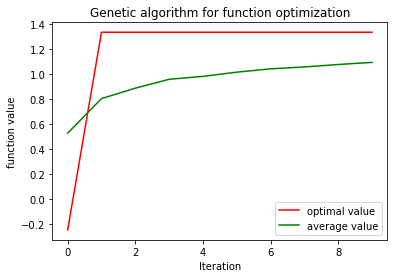

   weight_kpi  weight_spend  weight_bid        campaign_id    score
0    0.987611      0.954619    0.168607  23843419701490612  1.33178
optimal_weight: [0.98761054 0.95461908 0.16860692]


In [48]:
if __name__ == "__main__":
#     main()
    import gc
    gc.collect()
    main(campaign_id=23843419701490612)

In [54]:
!jupyter nbconvert --to script genetic_algorithm.ipynb

[NbConvertApp] Converting notebook genetic_algorithm.ipynb to script
[NbConvertApp] Writing 17563 bytes to genetic_algorithm.py
